<a href="https://colab.research.google.com/github/jhlee508/pytorch-advanced/blob/master/chapter1_image_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chapter1. Requirements

### Version Check

In [ ]:
# 파이썬
import sys

print("Python version: {}".format(sys.version))

Python version: 3.7.12 (default, Sep 10 2021, 00:21:48) 
[GCC 7.5.0]


In [ ]:
# 파이토치 (!pip install torch torchvision)
import torch

print("Torch version:{}".format(torch.__version__))
print("cuda version: {}".format(torch.version.cuda))
print("cudnn version:{}".format(torch.backends.cudnn.version()))

Torch version:1.10.0+cu111
cuda version: 11.1
cudnn version:8005


In [ ]:
# Cuda 및 CuDNN
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Oct_12_20:09:46_PDT_2020
Cuda compilation tools, release 11.1, V11.1.105
Build cuda_11.1.TC455_06.29190527_0


In [ ]:
# GPU
!nvidia-smi

Wed Dec 29 06:24:44 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Git Clone

In [ ]:
!git clone https://github.com/YutaroOgawa/pytorch_advanced.git

Cloning into 'pytorch_advanced'...
remote: Enumerating objects: 548, done.
remote: Counting objects: 100% (69/69), done.
remote: Compressing objects: 100% (51/51), done.
remote: Total 548 (delta 34), reused 45 (delta 18), pack-reused 479
Receiving objects: 100% (548/548), 17.75 MiB | 34.62 MiB/s, done.
Resolving deltas: 100% (293/293), done.


In [ ]:
%cd pytorch_advanced/

/content/pytorch_advanced


In [ ]:
!ls

1_image_classification	 7_nlp_sentiment_transformer
2_objectdetection	 8_nlp_sentiment_bert
3_semantic_segmentation  9_video_classification_eco
4_pose_estimation	 etc
5_gan_generation	 LICENSE
6_gan_anomaly_detection  README.md


In [ ]:
%cd 1_image_classification/

/content/pytorch_advanced/1_image_classification


In [ ]:
!pwd

/content/pytorch_advanced/1_image_classification


In [ ]:
!ls

1-1_load_vgg.ipynb
1-1_load_vgg_on_GoogleColab.ipynb
1-3_transfer_learning.ipynb
1_3_transfer_learning_on_GoogleColab.ipynb
1-5_fine_tuning.ipynb
data
make_folders_and_data_downloads.ipynb
utils


### Prepare Files

In [ ]:
import os
import urllib.request
import zipfile

In [ ]:
# data 폴더가 존재하지 않는 경우 실행
data_dir = "./data/"
if not os.path.exists(data_dir):
    os.mkdir(data_dir)

In [ ]:
# ImageNet의 class_index를 다운로드
# Keras에서 제공하는 항목
# https://github.com/fchollet/deep-learning-models/blob/master/imagenet_utils.py

url = "https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json"
save_path = os.path.join(data_dir, "imagenet_class_index.json")

if not os.path.exists(save_path):
    urllib.request.urlretrieve(url, save_path)

In [ ]:
# 1.3절에서 사용하는 개미와 벌의 화상 데이터를 다운로드하여 압축을 해제한다
# PyTorch의 튜토리얼로 제공되는 항목
# https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

url = "https://download.pytorch.org/tutorial/hymenoptera_data.zip"
save_path = os.path.join(data_dir, "hymenoptera_data.zip")

if not os.path.exists(save_path):
    urllib.request.urlretrieve(url, save_path)

    # ZIP 파일을 읽는다
    zip = zipfile.ZipFile(save_path)
    zip.extractall(data_dir)  # ZIP을 압축 해제
    zip.close()  # ZIP 파일을 닫는다

    # ZIP 파일을 삭제
    os.remove(save_path)

# Chapter1. 화상 분류와 전이학습 (VGG)

## 1.1 학습된 VGG 모델을 사용하는 방법

### Import Libraries
- 패키지 import 및 PyTorch 버전 확인

In [ ]:
# 패키지 import
import numpy as np
import json
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torchvision
from torchvision import models, transforms

In [ ]:
# PyTorch 버전 확인
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

PyTorch Version:  1.10.0+cu111
Torchvision Version:  0.11.1+cu111


### Load Pretrained Model (VGG-16)
- 학습된 VGG-16 모델 불러오기

In [ ]:
# 학습된 VGG-16 모델을 읽어오기
# VGG-16 모델의 인스턴스 생성
use_pretrained = True  # 학습된 파라미터 사용
net = models.vgg16(pretrained=use_pretrained)
net.eval()  # 추론 모드(평가 모드)로 설정

# 모델의 네트워크 구성 출력
print(net)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

### Pre-process Class
- 입력 화상의 전처리 클래스를 작성

In [ ]:
# 입력 화상의 전처리 클래스
class BaseTransform():
    """
    화상의 크기를 리사이즈하고 색상을 표준화한다.

    Attributes
    ----------
    resize : int
        리사이즈 대상 이미지의 크기.
    mean : (R, G, B)
        각 색상 채널의 평균 값.
    std : (R, G, B)
        각 색상 채널의 표준 편차.
    """

    def __init__(self, resize, mean, std):
        self.base_transform = transforms.Compose([
            #transforms.Resize(resize),  # 짧은 변의 길이가 resize의 크기가 된다
            transforms.CenterCrop(resize),  # 이미지 중앙을 resize × resize으로 자르기
            transforms.ToTensor(),  # Torch 텐서로 변환
            #transforms.Normalize(mean, std)  # 색상 정보의 표준화
        ])

    def __call__(self, img):
        return self.base_transform(img)

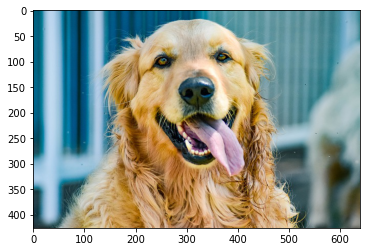

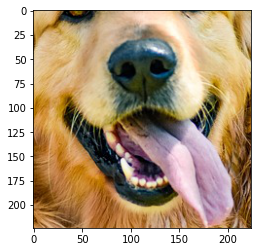

In [ ]:
# 이미지 전처리 동작 확인

# 1. 화상 읽기
image_file_path = './data/goldenretriever-3724972_640.jpg'
img = Image.open(image_file_path)  # PIL -> [높이][너비][색RGB]

# 2. 원본 화상 표시
plt.imshow(img)
plt.show()

# 3. 화상 전처리 및 처리된 이미지의 표시
resize = 224
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)
transform = BaseTransform(resize, mean, std) # 전처리 인스턴스 생성 
img_transformed = transform(img)  # torch.Size([3, 224, 224])

# (색상, 높이, 너비)을(높이, 너비, 색상)으로 변환하고 0 ~ 1 사이의 값을 제한하여 표시
img_transformed = img_transformed.numpy().transpose((1, 2, 0))
img_transformed = np.clip(img_transformed, 0, 1)
plt.imshow(img_transformed)
plt.show()

### Post-process Class
- 출력 결과에서 라벨을 예측하는 후처리 클래스를 작성

In [ ]:
# ILSVRC 라벨 정보를 읽어 사전형 변수를 생성합니다
ILSVRC_class_index = json.load(open('./data/imagenet_class_index.json', 'r'))
ILSVRC_class_index

{'0': ['n01440764', 'tench'],
 '1': ['n01443537', 'goldfish'],
 '2': ['n01484850', 'great_white_shark'],
 '3': ['n01491361', 'tiger_shark'],
 '4': ['n01494475', 'hammerhead'],
 '5': ['n01496331', 'electric_ray'],
 '6': ['n01498041', 'stingray'],
 '7': ['n01514668', 'cock'],
 '8': ['n01514859', 'hen'],
 '9': ['n01518878', 'ostrich'],
 '10': ['n01530575', 'brambling'],
 '11': ['n01531178', 'goldfinch'],
 '12': ['n01532829', 'house_finch'],
 '13': ['n01534433', 'junco'],
 '14': ['n01537544', 'indigo_bunting'],
 '15': ['n01558993', 'robin'],
 '16': ['n01560419', 'bulbul'],
 '17': ['n01580077', 'jay'],
 '18': ['n01582220', 'magpie'],
 '19': ['n01592084', 'chickadee'],
 '20': ['n01601694', 'water_ouzel'],
 '21': ['n01608432', 'kite'],
 '22': ['n01614925', 'bald_eagle'],
 '23': ['n01616318', 'vulture'],
 '24': ['n01622779', 'great_grey_owl'],
 '25': ['n01629819', 'European_fire_salamander'],
 '26': ['n01630670', 'common_newt'],
 '27': ['n01631663', 'eft'],
 '28': ['n01632458', 'spotted_salama

In [ ]:
# 출력 결과에서 라벨을 예측하는 후처리 클래스
class ILSVRCPredictor():
    """
    ILSVRC 데이터에 대한 모델의 출력에서 라벨을 구한다.

    Attributes
    ----------
    class_index : dictionary
            클래스 index와 라벨명을 대응시킨 사전형 변수.
    """

    def __init__(self, class_index):
        self.class_index = class_index

    def predict_max(self, out):
        """
        최대 확률의 ILSVRC 라벨명을 가져옵니다.

        Parameters
        ----------
        out : torch.Size([1, 1000])
            Net에서의 출력.

        Returns
        -------
        predicted_label_name : str
            가장 예측 확률이 높은 라벨명
        """
        maxid = np.argmax(out.detach().numpy())
        predicted_label_name = self.class_index[str(maxid)][1]

        return predicted_label_name

### Prediction
- 학습된 VGG 모델로 화상 예측

In [ ]:
# ILSVRC 라벨 정보를 읽어 사전형 변수를 생성
ILSVRC_class_index = json.load(open('./data/imagenet_class_index.json', 'r'))

# ILSVRCPredictor 인스턴스 생성
predictor = ILSVRCPredictor(ILSVRC_class_index)

# 입력 화상 읽기
image_file_path = './data/goldenretriever-3724972_640.jpg'
img = Image.open(image_file_path)  # [높이][너비][색RGB]

# 전처리 후, 배치 크기의 차원을 추가
transform = BaseTransform(resize, mean, std)  # 전처리 클래스 작성
img_transformed = transform(img)  # torch.Size([3, 224, 224])
inputs = img_transformed.unsqueeze(0)  # torch.Size([1, 3, 224, 224])

# 모델에 입력하고, 모델 출력을 라벨로 변환
out = net(inputs)  # torch.Size([1, 1000])
result = predictor.predict_max(out)

# 예측 결과를 출력
print("입력 화상의 예측 결과: ", result)

입력 화상의 예측 결과:  golden_retriever


---

## 1.3 전이학습 구현

### Import Libraries

In [ ]:
# 패키지 import
import glob
import os.path as osp
import random
import numpy as np
import json
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data # Dataset 클래스
import torchvision
from torchvision import models, transforms

In [ ]:
# 난수 시드 설정
torch.manual_seed(1234)
np.random.seed(1234)
random.seed(1234)

### Dataset

In [ ]:
# 입력 화상의 전처리 클래스
# 훈련 시와 추론 시 처리가 다르게 설정
class ImageTransform():
    """
    화상 전처리 클래스. 훈련시, 검증시의 동작이 다르다.
    화상 크기를 리사이즈하고, 색상을 표준화한다.
    훈련시에는 RandomResizedCrop과 RandomHorizontalFlip으로 데이터를 확장한다.

    Attributes
    ----------
    resize : int
        리사이즈 대상 화상의 크기.
    mean : (R, G, B)
        각 색상 채널의 평균 값.
    std : (R, G, B)
        각 색상 채널의 표준 편차.
    """

    def __init__(self, resize, mean, std):
        self.data_transform = {
            'train': transforms.Compose([
                transforms.RandomResizedCrop(
                    resize, scale=(0.5, 1.0)),  # 데이터 확장 (증강)
                transforms.RandomHorizontalFlip(),  # 데이터 확장
                transforms.ToTensor(),  # 텐서로 변환
                transforms.Normalize(mean, std)  # 표준화
            ]),
            'val': transforms.Compose([
                transforms.Resize(resize),  # 리사이즈
                transforms.CenterCrop(resize),  # 이미지 중앙을 resize × resize로 자른다
                transforms.ToTensor(),  # 텐서로 변환
                transforms.Normalize(mean, std)  # 표준화
            ])
        }

    def __call__(self, img, phase='train'):
        """
        Parameters
        ----------
        phase : 'train' or 'val'
            전처리 모드를 지정.
        """
        return self.data_transform[phase](img)

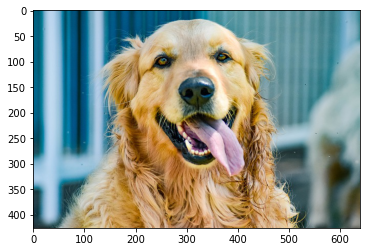

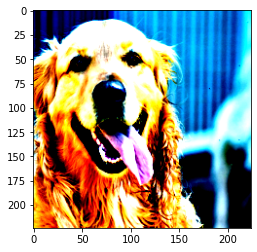

In [ ]:
# 훈련시 화상 전처리 동작 확인
# 실행할 때마다 처리 결과 화상이 바뀜

# 1. 화상 읽기
image_file_path = './data/goldenretriever-3724972_640.jpg'
img = Image.open(image_file_path)   # [높이][폭][색RGB]

# 2. 원본 화상 표시
plt.imshow(img)
plt.show()

# 3. 화상 전처리, 처리된 화상을 표시
size = 224
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)

transform = ImageTransform(size, mean, std)
img_transformed = transform(img, phase="train")  # torch.Size([3, 224, 224])

# (색상, 높이, 너비)를 (높이, 너비, 색상)으로 변환하고 0-1로 값을 제한해 표시
img_transformed = img_transformed.numpy().transpose((1, 2, 0))
img_transformed = np.clip(img_transformed, 0, 1)
plt.imshow(img_transformed)
plt.show()

In [ ]:
# 개미와 벌의 화상 파일의 경로 리스트를 작성
def make_datapath_list(phase="train"):
    """
    데이터의 경로를 저장한 리스트를 작성한다.

    Parameters
    ----------
    phase : 'train' or 'val'
        훈련 데이터 또는 검증 데이터를 지정

    Returns
    -------
    path_list : list
        데이터 경로를 저장한 리스트
    """

    rootpath = "./data/hymenoptera_data/"
    target_path = osp.join(rootpath+phase+'/**/*.jpg')
    print(phase + " 데이터 경로:" + target_path)

    path_list = []  # 이 리스트에 경로를 저장한다

    # glob을 이용하여 하위 디렉토리의 파일 경로를 가져온다
    for path in glob.glob(target_path):
        path_list.append(path)

    return path_list


# 실행
train_list = make_datapath_list(phase="train")
val_list = make_datapath_list(phase="val")

print("train 이미지 List:")
train_list

train 데이터 경로:./data/hymenoptera_data/train/**/*.jpg
val 데이터 경로:./data/hymenoptera_data/val/**/*.jpg
train 이미지 List:


['./data/hymenoptera_data/train/ants/45472593_bfd624f8dc.jpg',
 './data/hymenoptera_data/train/ants/226951206_d6bf946504.jpg',
 './data/hymenoptera_data/train/ants/201790779_527f4c0168.jpg',
 './data/hymenoptera_data/train/ants/1489674356_09d48dde0a.jpg',
 './data/hymenoptera_data/train/ants/424873399_47658a91fb.jpg',
 './data/hymenoptera_data/train/ants/460372577_f2f6a8c9fc.jpg',
 './data/hymenoptera_data/train/ants/474806473_ca6caab245.jpg',
 './data/hymenoptera_data/train/ants/334167043_cbd1adaeb9.jpg',
 './data/hymenoptera_data/train/ants/342438950_a3da61deab.jpg',
 './data/hymenoptera_data/train/ants/1262877379_64fcada201.jpg',
 './data/hymenoptera_data/train/ants/6240338_93729615ec.jpg',
 './data/hymenoptera_data/train/ants/1030023514_aad5c608f9.jpg',
 './data/hymenoptera_data/train/ants/484293231_e53cfc0c89.jpg',
 './data/hymenoptera_data/train/ants/2278278459_6b99605e50.jpg',
 './data/hymenoptera_data/train/ants/termite-vs-ant.jpg',
 './data/hymenoptera_data/train/ants/22465571

In [ ]:
# 개미와 벌의 이미지에 대한 Dataset을 작성한다
class HymenopteraDataset(data.Dataset): # Dataset 클래스 상속
    """
    개미(0)와 벌(1) 화상의 Dataset 클래스. 
    PyTorch의 Dataset 클래스를 상속한다.

    Attributes
    ----------
    file_list : 리스트
        화상 경로를 저장한 리스트
    transform : object
        전처리 클래스의 인스턴스
    phase : 'train' or 'test'
        학습인지 훈련인지를 설정한다.
    """

    def __init__(self, file_list, transform=None, phase='train'):
        self.file_list = file_list  # 파일 경로 리스트
        self.transform = transform  # 전처리 클래스의 인스턴스
        self.phase = phase  # train or val 지정

    def __len__(self):
        '''화상 개수를 반환'''
        return len(self.file_list)

    def __getitem__(self, index):
        '''
        전처리한 화상의 Tensor 형식의 데이터와 라벨을 취득
        '''

        # index번째의 화상을 로드
        img_path = self.file_list[index]
        img = Image.open(img_path)  # [높이][너비][색RGB]

        # 화상의 전처리를 실시
        img_transformed = self.transform(
            img, self.phase)  # torch.Size([3, 224, 224])

        # 화상 라벨을 파일 이름(경로)에서 추출
        if self.phase == "train":
            label = img_path[30:34]
        elif self.phase == "val":
            label = img_path[28:32]

        # 라벨을 숫자로 변경
        if label == "ants":
            label = 0
        elif label == "bees":
            label = 1

        return img_transformed, label


# 실행
train_dataset = HymenopteraDataset(
    file_list=train_list, transform=ImageTransform(size, mean, std), phase='train')

val_dataset = HymenopteraDataset(
    file_list=val_list, transform=ImageTransform(size, mean, std), phase='val')

# 동작 확인
index = 0
print("Sample image shape:", train_dataset.__getitem__(index)[0].size())
print("Sample image label:", train_dataset.__getitem__(index)[1])

Sample shape: torch.Size([3, 224, 224])
Sample label: 0


### Dataloader

In [ ]:
# 미니 배치 크기 지정
batch_size = 32

# DataLoader 작성
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True)

val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False)

# 사전형 변수(딕셔너리)에 정리
dataloaders_dict = {"train": train_dataloader, "val": val_dataloader}

# 동작 확인
batch_iterator = iter(dataloaders_dict["train"])  # 반복자(iterator)로 변환
inputs, labels = next(
    batch_iterator)  # 첫번째 요소를 추출
print("Sample batch shape:", inputs.size())
print("Sample batch label:", labels)

Sample batch shape: torch.Size([32, 3, 224, 224])
Sample batch label: tensor([0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1,
        0, 0, 0, 0, 1, 1, 0, 0])


### Network Model

In [ ]:
# 학습된 VGG-16 모델을 로드
# VGG-16 모델의 인스턴스 생성
use_pretrained = True  # 학습된 파라미터를 사용
net = models.vgg16(pretrained=use_pretrained)

# VGG16의 마지막 출력층의 출력 유닛을 개미와 벌의 2개로 바꾼다
net.classifier[6] = nn.Linear(in_features=4096, out_features=2)

# 훈련 모드로 설정
net.train()

print('네트워크 설정 완료: 학습된 가중치를 읽어들여 훈련 모드로 설정했습니다.')

네트워크 설정 완료: 학습된 가중치를 읽어들여 훈련 모드로 설정했습니다.


### Loss Function

In [ ]:
# 손실 함수 설정
criterion = nn.CrossEntropyLoss()

### Optimizer

In [ ]:
# 전이학습에서 학습시킬 파라미터를 params_to_update 변수에 저장한다
params_to_update = []

# 학습시킬 파라미터 이름
update_param_names = ["classifier.6.weight", "classifier.6.bias"]

# 학습시킬 파라미터 이외에는 경사를 계산하지 않고, 변하지 않게 설정
for name, param in net.named_parameters():
    if name in update_param_names:
        param.requires_grad = True
        params_to_update.append(param)
        print(name)
    else:
        param.requires_grad = False

# params_to_update의 내용을 확인
print("---------------")
print(params_to_update)
print(params_to_update[0].shape)
print(params_to_update[1].shape)

classifier.6.weight
classifier.6.bias
---------------
[Parameter containing:
tensor([[-0.0099,  0.0059, -0.0100,  ...,  0.0076,  0.0084, -0.0120],
        [-0.0053,  0.0106,  0.0106,  ..., -0.0124, -0.0037,  0.0090]],
       requires_grad=True), Parameter containing:
tensor([-0.0142, -0.0058], requires_grad=True)]
torch.Size([2, 4096])
torch.Size([2])


In [ ]:
# 최적화 기법 설정
optimizer = optim.SGD(params=params_to_update, lr=0.001, momentum=0.9)

### Train (+ Validation)

In [ ]:
# 모델을 학습시키는 함수를 작성
def train_model(net, dataloaders_dict, criterion, optimizer, num_epochs):

    # epoch 루프
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-------------')

        # epoch별 학습 및 검증 루프
        for phase in ['train', 'val']:
            if phase == 'train':
                net.train()  # 모델을 훈련 모드로
            else:
                net.eval()   # 모델을 검증 모드로

            epoch_loss = 0.0  # epoch 손실의 합
            epoch_corrects = 0  # epoch 정답의 수

            # 미 학습시 검증 성능을 확인하기 위해 epoch=0의 훈련 생략
            if (epoch == 0) and (phase == 'train'):
                continue

            # 데이터 로더로 미니 배치를 꺼내는 루프
            for inputs, labels in tqdm(dataloaders_dict[phase]):

                # optimizer를 초기화 (매개변수 경사도를 0으로 설정)
                optimizer.zero_grad()

                # 순전파(forward) 계산
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = net(inputs)
                    loss = criterion(outputs, labels)  # 손실을 계산
                    _, preds = torch.max(outputs, 1)  # 라벨을 예측 (각 row 마다 최댓값을 구함)
                    
  
                    # 훈련시에는 오차 역전파
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                    # 반복 결과 계산
                    # loss 합계 갱신
                    epoch_loss += loss.item() * inputs.size(0) # loss * batch_size
                    # 정답 수의 합계 갱신
                    epoch_corrects += torch.sum(preds == labels.data)

            # epoch 당 loss와 정답률 표시
            epoch_loss = epoch_loss / len(dataloaders_dict[phase].dataset)
            epoch_acc = epoch_corrects.double(
            ) / len(dataloaders_dict[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

In [ ]:
# 학습 및 검증 실시
num_epochs=2
train_model(net, dataloaders_dict, criterion, optimizer, num_epochs=num_epochs)

Epoch 1/2
-------------


100%|██████████| 5/5 [00:34<00:00,  6.89s/it]


val Loss: 0.8288 Acc: 0.3922
Epoch 2/2
-------------


100%|██████████| 8/8 [00:53<00:00,  6.64s/it]


train Loss: 0.5474 Acc: 0.7160


100%|██████████| 5/5 [00:32<00:00,  6.57s/it]

val Loss: 0.1734 Acc: 0.9608


## 1.5 파인튜닝 구현

### Import Libraries

In [ ]:
# 패키지 import
import numpy as np
import random

import torch
import torch.nn as nn
import torch.optim as optim

from torchvision import models

from tqdm import tqdm

In [ ]:
# 난수 시드 설정
torch.manual_seed(1234)
np.random.seed(1234)
random.seed(1234)

### Dataset & Dataloader

In [ ]:
!ls

1-1_load_vgg.ipynb
1-1_load_vgg_on_GoogleColab.ipynb
1-3_transfer_learning.ipynb
1_3_transfer_learning_on_GoogleColab.ipynb
1-5_fine_tuning.ipynb
data
make_folders_and_data_downloads.ipynb
utils


In [ ]:
# 1.3절에서 작성한 클래스를 utils 폴더의 dataloader_image_classification.py에 기재하여 사용합니다
from utils.dataloader_image_classification import ImageTransform, make_datapath_list, HymenopteraDataset

# 개미와 벌의 이미지 파일 경로 리스트를 작성
train_list = make_datapath_list(phase="train")
val_list = make_datapath_list(phase="val")

# Dataset을 만든다
size = 224
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)
train_dataset = HymenopteraDataset(
    file_list=train_list, transform=ImageTransform(size, mean, std), phase='train')

val_dataset = HymenopteraDataset(
    file_list=val_list, transform=ImageTransform(size, mean, std), phase='val')


# DataLoader를 만든다
batch_size = 32

train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True)

val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False)

# 사전 객체에 정리
dataloaders_dict = {"train": train_dataloader, "val": val_dataloader}

./data/hymenoptera_data/train/**/*.jpg
./data/hymenoptera_data/val/**/*.jpg


### Network Model

In [ ]:
# 학습된 VGG-16 모델을 로드

# VGG-16 모델의 인스턴스를 생성
use_pretrained = True  # 학습된 파라미터를 사용
net = models.vgg16(pretrained=use_pretrained)

# VGG16의 마지막 출력층의 출력 유닛을 개미와 벌의 2개로 바꾸기
net.classifier[6] = nn.Linear(in_features=4096, out_features=2)

# 훈련 모드로 설정
net.train()

print('네트워크 설정 완료: 학습된 가중치를 로드하고 훈련 모드로 설정했습니다')

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

네트워크 설정 완료: 학습된 가중치를 로드하고 훈련 모드로 설정했습니다


### Loss Function

In [ ]:
# 손실 함수의 설정
criterion = nn.CrossEntropyLoss()

### Optimizer

In [ ]:
# 파인 튜닝으로 학습할 파라미터를 params_to_update 변수의 1~3에 저장한다

params_to_update_1 = []
params_to_update_2 = []
params_to_update_3 = []

# 학습시킬 층의 파라미터명을 지정
update_param_names_1 = ["features"]
update_param_names_2 = ["classifier.0.weight",
                        "classifier.0.bias", "classifier.3.weight", "classifier.3.bias"]
update_param_names_3 = ["classifier.6.weight", "classifier.6.bias"]

# 파라미터를 각각 리스트에 저장
for name, param in net.named_parameters():
    if update_param_names_1[0] in name:
        param.requires_grad = True
        params_to_update_1.append(param)
        print("params_to_update_1에 저장: ", name)

    elif name in update_param_names_2:
        param.requires_grad = True
        params_to_update_2.append(param)
        print("params_to_update_2에 저장: ", name)

    elif name in update_param_names_3:
        param.requires_grad = True
        params_to_update_3.append(param)
        print("params_to_update_3에 저장: ", name)

    else:
        param.requires_grad = False
        print("경사 계산없음. 학습하지 않음: ", name)

params_to_update_1에 저장:  features.0.weight
params_to_update_1에 저장:  features.0.bias
params_to_update_1에 저장:  features.2.weight
params_to_update_1에 저장:  features.2.bias
params_to_update_1에 저장:  features.5.weight
params_to_update_1에 저장:  features.5.bias
params_to_update_1에 저장:  features.7.weight
params_to_update_1에 저장:  features.7.bias
params_to_update_1에 저장:  features.10.weight
params_to_update_1에 저장:  features.10.bias
params_to_update_1에 저장:  features.12.weight
params_to_update_1에 저장:  features.12.bias
params_to_update_1에 저장:  features.14.weight
params_to_update_1에 저장:  features.14.bias
params_to_update_1에 저장:  features.17.weight
params_to_update_1에 저장:  features.17.bias
params_to_update_1에 저장:  features.19.weight
params_to_update_1에 저장:  features.19.bias
params_to_update_1에 저장:  features.21.weight
params_to_update_1에 저장:  features.21.bias
params_to_update_1에 저장:  features.24.weight
params_to_update_1에 저장:  features.24.bias
params_to_update_1에 저장:  features.26.weight
params_to_update_1

In [ ]:
# 최적화 기법 설정
optimizer = optim.SGD([
    {'params': params_to_update_1, 'lr': 1e-4}, # 10^-4 (작게 설정)
    {'params': params_to_update_2, 'lr': 5e-4}, # 5*10^-4
    {'params': params_to_update_3, 'lr': 1e-3}  # 10^-3 (크게 설정)
], momentum=0.9)

### Train (+ Validation)

In [ ]:
# 모델을 학습시키는 함수를 작성
def train_model(net, dataloaders_dict, criterion, optimizer, num_epochs):

    # 초기 설정
    # GPU가 사용 가능한지 확인
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("사용 장치: ", device)

    # 네트워크를 GPU로
    net.to(device)

    # 네트워크가 어느 정도 고정되면, 고속화시킨다
    torch.backends.cudnn.benchmark = True

    # epoch 루프
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-------------')

        # epoch별 훈련 및 검증 루프
        for phase in ['train', 'val']:
            if phase == 'train':
                net.train()  # 모델을 훈련 모드로
            else:
                net.eval()   # 모델을 검증 모드로

            epoch_loss = 0.0  # epoch 손실의 합
            epoch_corrects = 0  # epoch 정답수

            # 미학습시의 검증 성능을 확인하기 위해 epoch=0의 훈련은 생략
            if (epoch == 0) and (phase == 'train'):
                continue

            # 데이터 로더에서 미니 배치를 꺼내 루프
            for inputs, labels in tqdm(dataloaders_dict[phase]):

                # GPU가 사용 가능하면 GPU에 데이터 보내기
                inputs = inputs.to(device)
                labels = labels.to(device)

                # optimizer를 초기화
                optimizer.zero_grad()

                # 순전파(forward) 계산
                with torch.set_grad_enabled(phase == 'train'): # require_grad = 
                    outputs = net(inputs)
                    loss = criterion(outputs, labels)  # 손실 계산
                    _, preds = torch.max(outputs, 1)  # 라벨 예측

                    # 훈련시에는 오차 역전파법
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                    # 결과 계산
                    epoch_loss += loss.item() * inputs.size(0)  # loss의 합계를 갱신
                    # 정답 수의 합계를 갱신
                    epoch_corrects += torch.sum(preds == labels.data)

            # epoch별 loss와 정답률을 표시
            epoch_loss = epoch_loss / len(dataloaders_dict[phase].dataset)
            epoch_acc = epoch_corrects.double(
            ) / len(dataloaders_dict[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

In [ ]:
# 학습 및 검증을 실행
num_epochs=2
train_model(net, dataloaders_dict, criterion, optimizer, num_epochs=num_epochs)

사용 장치:  cuda:0
Epoch 1/2
-------------


100%|██████████| 5/5 [00:03<00:00,  1.33it/s]


val Loss: 0.7704 Acc: 0.4444
Epoch 2/2
-------------


100%|██████████| 8/8 [00:06<00:00,  1.17it/s]


train Loss: 0.5206 Acc: 0.7202


100%|██████████| 5/5 [00:01<00:00,  2.64it/s]

val Loss: 0.1746 Acc: 0.9542


### Network Save and Load
- 학습한 네트워크의 저장 및 로드

In [ ]:
# PyTorch 네트워크 파라미터 저장
save_path = './weights_fine_tuning.pth'
torch.save(net.state_dict(), save_path)

In [ ]:
# PyTorch 네트워크 파라미터 로드
load_path = './weights_fine_tuning.pth'
load_weights = torch.load(load_path)
net.load_state_dict(load_weights)

# GPU 상에 저장된 가중치를 CPU에 로드할 경우
load_weights = torch.load(load_path, map_location={'cuda:0': 'cpu'})
net.load_state_dict(load_weights)